# III - Comparison with a State-of-the-Art LLM

In this notebook, we aim to compare the performance obtained in `2_prediction_benchmark.ipynb` with that of a recent large language model (LLM) for sentiment classification on our IMDB dataset.

We will use pretrained deep learning models available on the Hugging Face platform. Among the available models, we choose the **DistilBERT base uncased fine-tuned on SST-2**. This model is a version of the base **DistilBERT** that has been fine-tuned on the **Stanford Sentiment Treebank v2 (SST-2)** dataset.

The **SST-2** corpus consists of 11,855 individual sentences extracted from movie reviews. These sentences were parsed using the Stanford Parser and further expanded into 215,154 unique phrases, each annotated for sentiment (positive or negative) by three human judges. The dataset originates from the work of Pang and Lee (2005) and allows for fine-grained sentiment analysis based on syntactic structure.

This model is particularly well-suited for **binary sentiment classification** in English, which is exactly the task we aim to perform here.

> **Note:** The original **DistilBERT** model is a *distilled* version of BERT, introduced in the paper:
>
> **Sanh, V., Debut, L., Chaumond, J., & Wolf, T. (2020)**. *DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter*. arXiv preprint [arXiv:1910.01108](https://arxiv.org/abs/1910.01108)
>
> The purpose of model distillation is to compress large models like BERT into smaller ones while preserving most of their performance. This makes the model faster and more lightweight, significantly reducing training and inference time.

In summary, the DistilBERT SST-2 model is a lightweight yet powerful model specifically optimized for sentiment classification on movie reviews, making it an ideal benchmark for our task.

----

In [1]:
!pip install huggingface_hub[hf_xet]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 26.9 MB/s eta 0:00:0000:0100:01


In [2]:
"""Importation of libraries"""
import torch
import matplotlib.pyplot as plt
import transformers
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

/home/onyxia/work/ensae_3A_S2_NLP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# loading training and test data
df_train = pd.read_parquet("data/df_train.parquet")
df_test = pd.read_parquet("data/df_test.parquet")

In [4]:
# reduction of df_test
df_test_sample = df_test.sample(n=2000, random_state=42).copy()
df_test_sample.head()

,texte,label
6868,Warning: If the Coen Brothers or David Lynch d...,1
24016,I deliberately did not read any reviews of thi...,0
9668,"I give this a 10 out of 10, not because the pl...",1
13640,"This film gives new meaning to the term ""uneve...",0
14018,While I can't say whether or not Larry Hama ev...,1


In [5]:
"""Loading the model and tokenizer"""

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [6]:
"""Function to predict sentiment with fine-tuned DistilBERT model"""

def predict_sentiment(texts):
    # tokenization
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    # prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_labels = torch.argmax(predictions, dim=1).tolist()
    
    return predicted_labels


In [7]:
# apply the predict_sentiment fuction to some examples
print(predict_sentiment("It's such a stupid movie"))
print(predict_sentiment("It's such a great movie"))

[0]
[1]


In [8]:
"""PREDICTION on our test dataset"""

# apply the predict_sentiment function
predicted_labels = predict_sentiment(df_test_sample['texte'].tolist())

# add predictions to dataframe
df_test_sample['predicted_label'] = predicted_labels

Average accuracy: 0.8980 (89.80%)

Classification report:
              precision    recall  f1-score   support

negative (0)       0.88      0.92      0.90      1002
positive (1)       0.91      0.88      0.90       998

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000


Confusion matrix:
[[919  83]
 [121 877]]


<Figure size 1000x600 with 0 Axes>

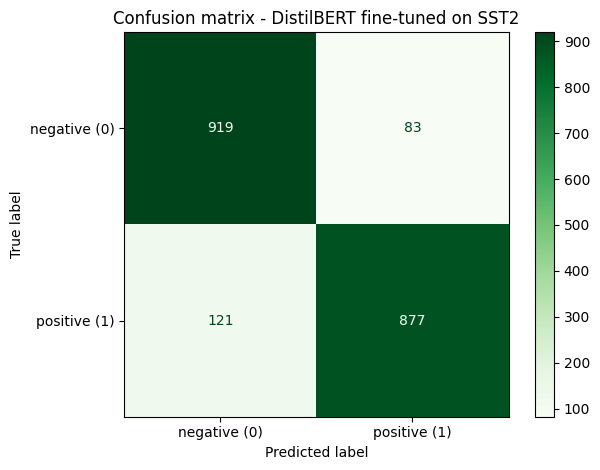

In [15]:
""" Compute results and metrics, plot and saves confusion matrix"""

df_results = df_test_sample.copy()

y_true = df_results['label']
y_pred = df_results['predicted_label']

# compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Average accuracy: {accuracy:.4f} ({accuracy:.2%})")

# generate classification report
report = classification_report(y_true, y_pred, target_names=['negative (0)', 'positive (1)'])
print("\nClassification report:")
print(report)

# compute and print confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:")
print(cm)

# visualize confusion matrix
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative (0)', 'positive (1)'])
disp.plot(cmap=plt.cm.Greens, values_format='d')
plt.title('Confusion matrix - DistilBERT fine-tuned on SST2')
plt.tight_layout()  # <-- Ajout ici pour éviter de couper les éléments
plt.savefig('output/confusion_matrix_distilbert.png', dpi=300)
plt.show()
